In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv('./dataset/minmaxtemp.csv')
data.info()
data.sort_values('Date')
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB
(3650, 2)


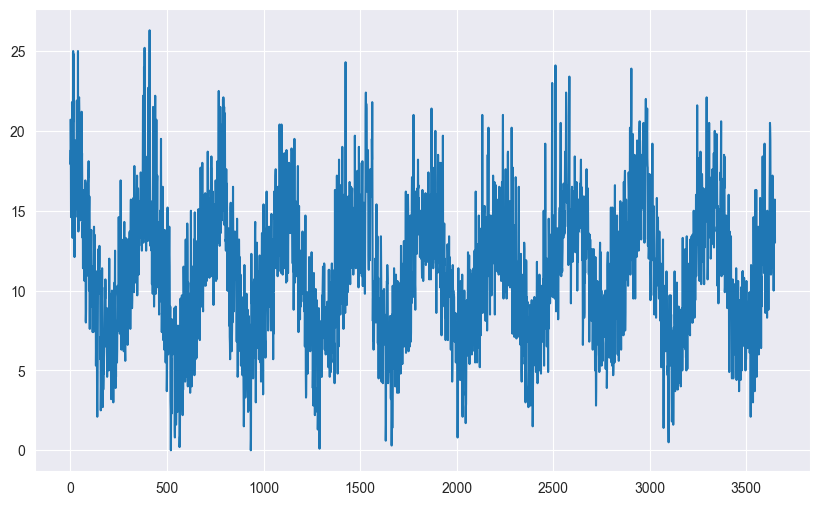

In [2]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,6))
plt.plot(data[['Temp']])

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
data['Temp'] = scaler.fit_transform(data['Temp'].values.reshape(-1,1))

In [4]:
def train_test_split(stock,lookback):
    data_raw = stock.to_numpy()
    data = []
    for i in range(len(data_raw)-lookback):
        data.append(data_raw[i:i+lookback])
    data = np.array(data)
    print(data.shape)
    test_size = int(np.round(0.2*data.shape[0]))
    train_size = data.shape[0]-test_size
    x_train = data[:train_size,:-1,:]
    y_train = data[:train_size,-1,:]
    x_test = data[train_size:,:-1,:]
    y_test = data[train_size:,-1,:]
    return [x_train,y_train,x_test,y_test]
    
lookback = 10
x_train,y_train,x_test,y_test = train_test_split(data[['Temp']],lookback)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3640, 10, 1)
(2912, 9, 1)
(2912, 1)
(728, 9, 1)
(728, 1)


In [5]:
import torch
import torch.nn as nn

In [6]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [7]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,layer_num):
        super(LSTM,self).__init__()
        self.layer_num = layer_num
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,self.hidden_size,layer_num,batch_first=True)
        self.fc = nn.Linear(self.hidden_size,output_size)
        
    def forward(self,x):
        h0 = torch.zeros(self.layer_num,x.size(0),self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.layer_num,x.size(0),self.hidden_size).requires_grad_()
        out,(hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
        out = self.fc(out[:,-1,:])
        return out
    


In [8]:
input_size = 1
output_size = 1
hidden_size = 64
layer_num = 2
num_epochs = 100
model = LSTM(input_size,hidden_size,output_size,layer_num)
critierion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [9]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for i in range(num_epochs):
    y_train_pred = model(x_train)
    loss = critierion(y_train_pred,y_train)
    print('Epoch ',i,'MSE: ',loss.item())
    hist[i] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time()-start_time
print('Training time:{}'.format(training_time))

Epoch  0 MSE:  0.16997498273849487
Epoch  1 MSE:  0.09729975461959839
Epoch  2 MSE:  0.15693005919456482
Epoch  3 MSE:  0.08665384352207184
Epoch  4 MSE:  0.0952896773815155
Epoch  5 MSE:  0.10330109298229218
Epoch  6 MSE:  0.102204330265522
Epoch  7 MSE:  0.09497416019439697
Epoch  8 MSE:  0.08444944769144058
Epoch  9 MSE:  0.07311279326677322
Epoch  10 MSE:  0.0656217560172081
Epoch  11 MSE:  0.06926780939102173
Epoch  12 MSE:  0.06696208566427231
Epoch  13 MSE:  0.05316847562789917
Epoch  14 MSE:  0.04702199250459671
Epoch  15 MSE:  0.05215013399720192
Epoch  16 MSE:  0.05690350756049156
Epoch  17 MSE:  0.051957860589027405
Epoch  18 MSE:  0.04631756246089935
Epoch  19 MSE:  0.04630941525101662
Epoch  20 MSE:  0.04807176813483238
Epoch  21 MSE:  0.047126658260822296
Epoch  22 MSE:  0.04657074064016342
Epoch  23 MSE:  0.04735394939780235
Epoch  24 MSE:  0.04799821972846985
Epoch  25 MSE:  0.04760659858584404
Epoch  26 MSE:  0.046273961663246155
Epoch  27 MSE:  0.04480667784810066
Epo

Text(0.5, 0, 'Epoch')

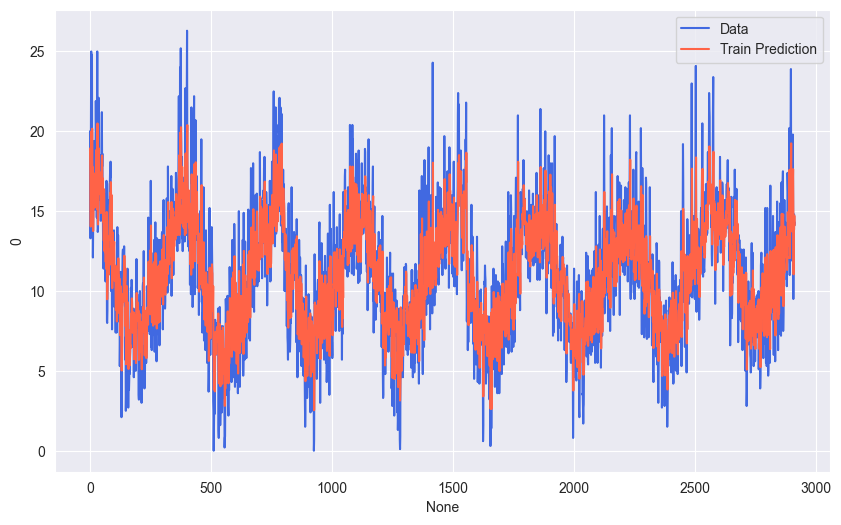

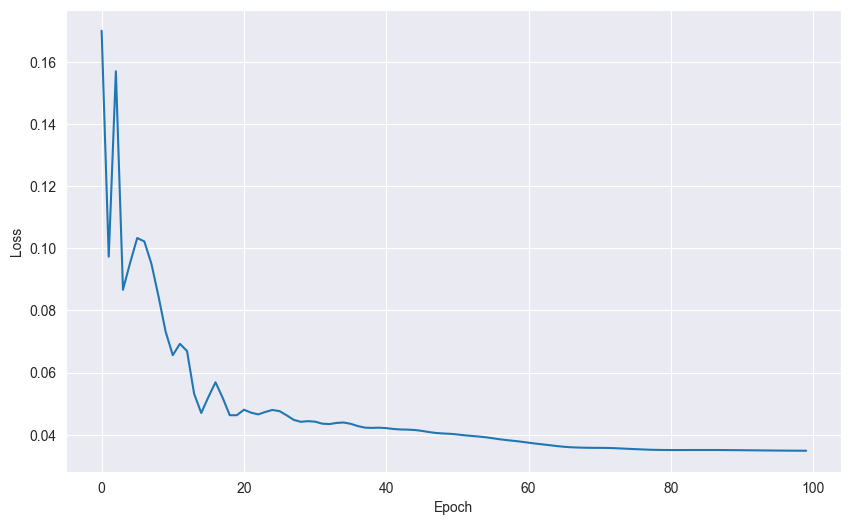

In [10]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(x=original.index,y=original[0],label='Data',color='royalblue')
ax = sns.lineplot(x=predict.index,y=predict[0],label='Train Prediction',color='tomato')

fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(data = hist)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')